# RNN and Learning Rate sweep on Synthetic Time Series Dataset from Week 1:


Coursera Colab Link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb

- RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
- Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.
- RNN only outputs the last sequence (last time step) by default, if we want to get the output for all the sequences (all time steps) to feed it into a lower RNN, we need to use return_sequences=True.
- RNN use 'tanh' as activation function by default.
- Simple RNN use the output as the state vector recurred (fed back) to the next time step.


Huber loss function: https://en.wikipedia.org/wiki/Huber_loss

Lambda tf keras layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda

tf.expand_dims: https://www.tensorflow.org/api_docs/python/tf/expand_dims


TF Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

np.newaxis: https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae

Keras Callbacks: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2.2.0-rc2


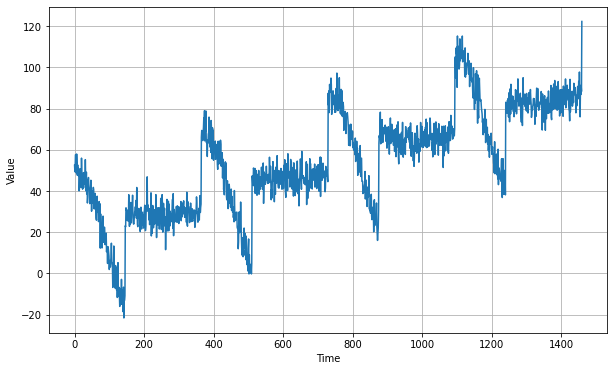

In [0]:
# Creating a synthetic Time Series:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Spliting the data into Training and Validation sets:

time_split = 1000

time_train = time[:time_split]
x_train = series[:time_split]

time_val = time[time_split:]
x_val = series[time_split:]

In [0]:
# Parameters for preparing the dataset ready for ML:

window_size = 20  # window_size is the number of features!
batch_size = 128
shuffle_buffer_size = 1000

# RNN Model with fixed learning rate:

In [0]:
# Function to window + capping + flattening + splitting + batching the dataset:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size) :
  dataset = tf.data.Dataset.from_tensor_slices(series)                                # create a tf dataset. we import the time series into tensorflow dataset using from_tensor_slices
  dataset = dataset.window(size=window_size + 1, shift = 1, drop_remainder=True)      # slice the dataset by windows. we add +1 into window_size as the additional one will be used as label!!!
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))              # flatten the data out to be easier to work with. we flatten the data into chuncks of the size of window_size+1
  dataset = dataset.shuffle(shuffle_buffer_size)                                      # once flattened it is easy to shuffle the order of the windows. it picks large dataset by groups of shuffle_buffer_size and then takes random samples. This speeds up the random shuffling in large datasets.
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))                    # splitting the data into features and labels (last one) using map and lambda function. this is stored in tuples.
  dataset = dataset.batch(batch_size).prefetch(1)                                     # the split dataset is batched in batches of the specified size.

  return dataset

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))  # we use the Lambda-function layer to expand the dataset (originally 2D) into the needed 3D dimension
model.add(tf.keras.layers.SimpleRNN(40, return_sequences=True))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.SimpleRNN(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.SimpleRNN(40))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another RNN underneath.
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 100.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the model:

history =  model.fit(train_dataset, epochs=50, verbose=1)

Epoch 1/50
8/8 [==============================] - 0s 15ms/step - loss: 178.6237 - mae: 180.2469 - mse: 33575.4688
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 75.2085 - mae: 77.9623 - mse: 8178.6025
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 42.4252 - mae: 42.7973 - mse: 2423.6892
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 27.6287 - mae: 28.5576 - mse: 1225.7039
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 20.0095 - mae: 20.5855 - mse: 688.8916
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 14.1147 - mae: 14.6318 - mse: 379.3457
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 10.4305 - mae: 11.0250 - mse: 243.1006
Epoch 8/50
8/8 [==============================] - 0s 11ms/step - loss: 8.4845 - mae: 8.9180 - mse: 183.4881
Epoch 9/50
8/8 [==============================] - 0s 13ms/step - loss: 7.9155 - mae: 8.4380 - mse: 166.5525
Epoch 10

1441
[array([[42.83507]], dtype=float32), array([[46.499275]], dtype=float32)]


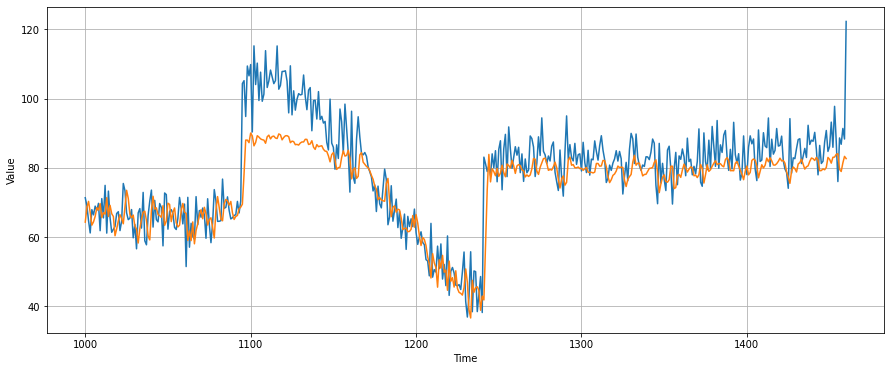

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = []
for time in range(len(series)-window_size) :
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))  # np.newaxis converts 1D into 2D arrays.

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:]  # !!! Careful here!!! -> the predictions index are shifted by window_size
results = np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

75.697464
6.406648


# RNN with learning rate sweep:

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))  # we use the Lambda-function layer to expand the dataset (originally 2D) into the needed 3D dimension
model.add(tf.keras.layers.SimpleRNN(40, return_sequences=True))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.SimpleRNN(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.SimpleRNN(40))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another RNN underneath.
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 100.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Callback to adapt the Learning Rate:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)



# Training the model:

history =  model.fit(train_dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
8/8 [==============================] - 0s 10ms/step - loss: 195.7154 - mae: 196.0726 - mse: 39496.7891 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 195.0722 - mae: 195.2820 - mse: 39180.3320 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 193.3684 - mae: 194.0109 - mse: 38674.8984 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 191.7916 - mae: 192.4081 - mse: 38041.1328 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 190.2995 - mae: 190.5235 - mse: 37300.9609 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 187.7607 - mae: 188.3582 - mse: 36460.5547 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 185.1628 - mae: 185.8786 - mse: 35511.4570 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 182.

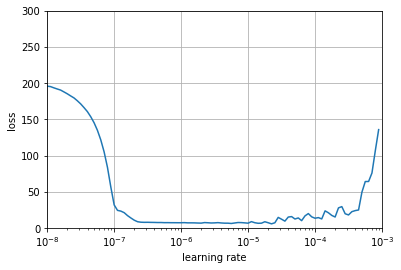

In [0]:
# Plotting the loss history vs learning rate:

lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.grid()
plt.show()

# Re-training the RNN with the best Learning Rate

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))  # we use the Lambda-function layer to expand the dataset (originally 2D) into the needed 3D dimension
model.add(tf.keras.layers.SimpleRNN(40, return_sequences=True))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.SimpleRNN(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.SimpleRNN(40))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another RNN underneath.
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 100.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the model:

history =  model.fit(train_dataset, epochs=400, verbose=1)

Epoch 1/400
8/8 [==============================] - 0s 11ms/step - loss: 79.5375 - mae: 82.2535 - mse: 9814.1777
Epoch 2/400
8/8 [==============================] - 0s 10ms/step - loss: 21.7453 - mae: 22.4301 - mse: 732.5629
Epoch 3/400
8/8 [==============================] - 0s 12ms/step - loss: 15.7456 - mae: 16.4143 - mse: 428.2216
Epoch 4/400
8/8 [==============================] - 0s 10ms/step - loss: 12.2264 - mae: 12.7814 - mse: 263.1697
Epoch 5/400
8/8 [==============================] - 0s 10ms/step - loss: 10.3278 - mae: 10.6405 - mse: 184.3757
Epoch 6/400
8/8 [==============================] - 0s 12ms/step - loss: 16.2301 - mae: 16.8110 - mse: 417.6665
Epoch 7/400
8/8 [==============================] - 0s 11ms/step - loss: 13.6413 - mae: 14.2229 - mse: 301.2567
Epoch 8/400
8/8 [==============================] - 0s 9ms/step - loss: 9.5780 - mae: 10.1128 - mse: 167.2284
Epoch 9/400
8/8 [==============================] - 0s 11ms/step - loss: 9.1466 - mae: 9.4663 - mse: 147.5026
Epoc

In [1]:
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss evolution')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((3, 8))
plt.title('loss evolution')
plt.legend()

plt.show()

NameError: ignored

1441
[array([[46.071854]], dtype=float32), array([[49.14301]], dtype=float32)]


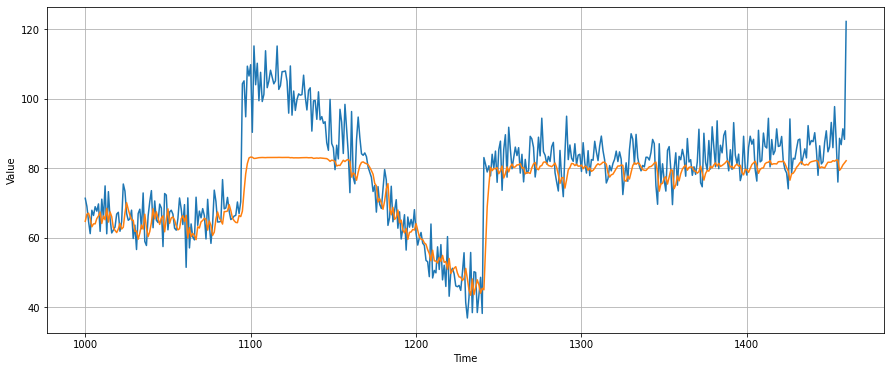

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = []
for time in range(len(series)-window_size) :
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))  # np.newaxis converts 1D into 2D arrays.

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:]  # !!! Careful here!!! -> the predictions index are shifted by window_size
results = np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

91.62179
6.824173
